## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx=9
ny=6
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [2]:
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [3]:
def compare_images(first_img,first_title,second_img, secon_title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(first_img)
    ax1.set_title(first_title, fontsize=50)
    ax2.imshow(second_img)
    ax2.set_title(secon_title, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

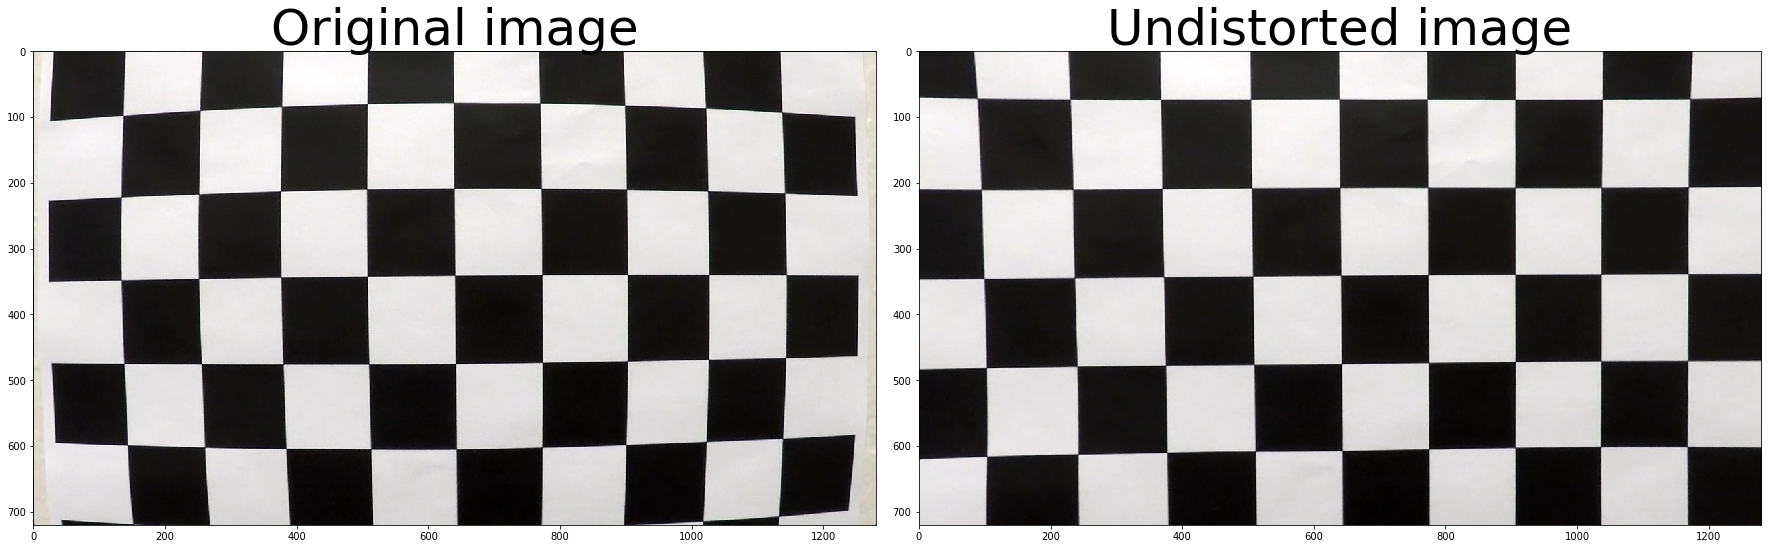

In [4]:
import matplotlib.image as mpimg
%matplotlib inline
img = mpimg.imread('camera_cal/calibration1.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)
compare_images(img,"Original image",undistorted, "Undistorted image")

## Gradients and color transforms

In [5]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [6]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


In [7]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [8]:
# Edit this function to create your own pipeline.
def combine_color_and_gradient(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary, combined_binary

In [91]:
def perspective_transform(img):
    src = np.float32([corners[0], corners[nx-1], corners[nx*(ny-1)], corners[nx*ny-1]])
    #define 4 destination points 
    height,width = img.shape[0], img.shape[1]
    src = np.float32([[200, height], [535,480], [745, 480], [1100, height]])
    dst = np.float32([[320, height], [320, 0],[980, 0],[980, height]])
    #get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    #warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (width, height), flags=cv2.INTER_LINEAR)
    return warped, M, src, dst, Minv

In [10]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
#compute second order polynomials
def compute_fits(lefty, leftx, righty, rightx):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    return left_fit, right_fit, left_fit_cr, right_fit_cr

In [53]:
def slide_windows_and_fit_polynomials(binary_warped, display, title):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit, right_fit, left_fit_cr, right_fit_cr = compute_fits(lefty, leftx,righty, rightx)
    
    if display:
            # Generate x and y values for plotting
        plt.figure()
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img, cmap="gray")
        plt.title(title)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    return left_fit, right_fit, left_lane_inds, right_lane_inds, left_fit_cr, right_fit_cr

In [19]:
def fit_polynomials_with_previous_fit(binary_warped,left_fit,right_fit, display, title):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit, right_fit, left_fit_cr, right_fit_cr = compute_fits(lefty, leftx, righty, rightx)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    if display:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.figure()
        plt.title(title)
        plt.imshow(result, cmap="gray")
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return left_fit, right_fit, left_lane_inds, right_lane_inds, left_fit_cr, right_fit_cr

In [145]:
#Calculate the new radii of curvature in meters
def curvature(img, left_fit_cr, right_fit_cr):
    y_eval=img.shape[0] #height of the image
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

In [83]:
def dist_from_center(img, left_fit, right_fit):
    height=img.shape[0]
    width=img.shape[1]
    car_pos=width/2
    leftx = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
    rightx = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]
    center=(leftx+rightx)/2
    return (car_pos-center)*xm_per_pix    

In [98]:
# draw the lanes on the unistorded image
def draw_lines(undist,warped, left_fit, right_fit, Minv):
    height = warped.shape[0]
    ploty = np.linspace(0, height-1, height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

In [104]:
def draw_radius_and_offset(img, left_curverad, right_curverad, offset):
    img_with_radius_and_offset = np.copy(img)
    font = cv2.FONT_HERSHEY_DUPLEX
    radius_text = 'Radius: ' + '{:04.3f}'.format((left_curverad+right_curverad)/2) + ' m'
    cv2.putText(img_with_radius_and_offset, radius_text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    offset_text = 'Offset: {:04.3f}'.format(offset) + ' m'
    cv2.putText(img_with_radius_and_offset, offset_text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return img_with_radius_and_offset

In [108]:
def sanity_check(left_fit,right_fit, h):
    ploty = np.linspace(0, h-1, h)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #Check the interception with the bottom line
    if left_fitx[h-1] > 400 or right_fitx[h-1] < 950:
        return False
    for i in range(0, len(ploty)):
        dist=right_fitx[i]-left_fitx[i]
        if dist < 450:
            return False
    return True

In [137]:
n=5
max_lost = 3
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fits
        self.current_fits = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 
    def add(self, fit):
        self.current_fits.append(fit)
        if len(self.current_fits) > n:
        #  keep newest n fits
            self.current_fits = self.current_fits[len(self.current_fits)-n:]
        self.best_fit = np.average(self.current_fits, axis=0)
 

class Tracker():
    def __init__(self):
        self.reset()

    def reset(self):
        self.left_line=None
        self.right_line=None
        self.lost_in_a_row = 0

tracker = Tracker()

In [21]:
def display_image(img, title,cmap="gray"):
    plt.figure()
    plt.title(title)
    plt.imshow(img,cmap=cmap)

In [153]:
ksize = 15
def pipeline(img, display=False, name=""):        
    undistorted= cal_undistort(img, objpoints, imgpoints)
    #grad_x = abs_sobel_thresh(undistorted, orient='x', thresh_min=20, thresh_max=100)
    #grad_y = abs_sobel_thresh(undistorted, orient='y', thresh_min=20, thresh_max=100)
    #mag_binary = mag_thresh(undistorted, sobel_kernel=ksize, mag_thresh=(30, 100))
    #dir_binary = dir_threshold(undistorted, sobel_kernel=ksize, thresh=(0.7, 1.3))
    #combined = np.zeros_like(dir_binary)
    #combined[((grad_x == 1) & (grad_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    color_gradient_stacked, color_gradient_combined = combine_color_and_gradient(undistorted)
    warped, M, src, dst, Minv = perspective_transform(color_gradient_combined)   
    
    if tracker.left_line==None :
        #print("sliding windows")
        tracker.left_line = Line()
        tracker.right_line = Line()
        #Slide windows to fit polynomials
        left_fit, right_fit, left_lane_inds, right_lane_inds, left_fit_cr, right_fit_cr = slide_windows_and_fit_polynomials (warped,display,name+"-windows_fit_polynomials")
    else:
        #Use existing polynomials
        #print("reusing existing")
        left_fit, right_fit = tracker.left_line.best_fit, tracker.right_line.best_fit
        left_fit, right_fit, left_lane_inds, right_lane_inds, left_fit_cr, right_fit_cr = fit_polynomials_with_previous_fit(warped,left_fit,right_fit,display,name+"-skip_windows_fit_polynomials")
    
    if sanity_check(left_fit, right_fit,undistorted.shape[0]):
        tracker.left_line.add(left_fit)
        tracker.right_line.add(right_fit) 
        # reinitialize the number of losts
        tracker.lost_in_a_row = 0
        # Use the averaged n last best fits
        left_fit, right_fit = tracker.left_line.best_fit, tracker.right_line.best_fit
    else:
        tracker.lost_in_a_row = tracker.lost_in_a_row + 1
        # sanity check failed and we either lost many fits in a row, or we have not fit any before
        if tracker.lost_in_a_row >= max_lost or tracker.left_line.best_fit == None:
            tracker.reset()
    
    left_curverad, right_curverad = curvature(warped, left_fit_cr, right_fit_cr)
    offset = dist_from_center(warped,left_fit,right_fit)
    undistorted_with_lanes = draw_lines(undistorted,warped, left_fit, right_fit, Minv)
    final_image = draw_radius_and_offset(undistorted_with_lanes, left_curverad, right_curverad, offset)
    if display:
        fit_polynomials_with_previous_fit(warped,left_fit,right_fit,display,name+"-skip_windows_fit_polynomials")
        display_image(img, name, cmap=None)
        display_image(undistorted, name+"-undistorted", cmap=None)
        #display_image(grad_x, name+"-gradient_x") 
        #display_image(grad_y, name+"-gradient_y") 
        #display_image(mag_binary, name+"-tresholded_magnitude")
        #display_image(dir_binary, name+"-Thresholded_grad_dir")
        #display_image(combined, name+"-combined_tresholds")
        #display_image(color_gradient_stacked, name+"-color_gradient_stacked")
        display_image(color_gradient_combined, name+"-color_gradient_combined")
        for point in src:
            plt.plot(point[0],point[1],".")
        display_image(warped, name+"-warped")
        for point in dst:
            plt.plot(point[0],point[1],".")
        print("curvature: ", left_curverad, 'm', right_curverad, 'm')
        print("dist from center: ", offset)
        display_image(undistorted_with_lanes, name+"-undistorted_with_lanes", cmap=None)
        display_image(final_image, name+"-final", cmap=None)
        print("Sanity check: ", sanity_check(left_fit, right_fit,undistorted.shape[0]))
    
    return final_image
        

curvature:  11637.4659022 m 2217.4065371 m
dist from center:  -0.0778012920341
Sanity check:  True
curvature:  10242.4730275 m 451048.882932 m
dist from center:  -0.103164635265
Sanity check:  True
curvature:  2341.75558605 m 2068.02743472 m
dist from center:  -0.208400385711
Sanity check:  True
curvature:  3439.51959975 m 658.095873419 m
dist from center:  -0.260378915644
Sanity check:  True
curvature:  1688.25470255 m 647.864562855 m
dist from center:  -0.231933139539
Sanity check:  True
curvature:  2292.99526052 m 1953.98422921 m
dist from center:  -0.037302878127
Sanity check:  True
curvature:  2285.10422687 m 4672.41271499 m
dist from center:  -0.290371727319
Sanity check:  True
curvature:  4243.34126617 m 3274.48854353 m
dist from center:  -0.37742816774
Sanity check:  True


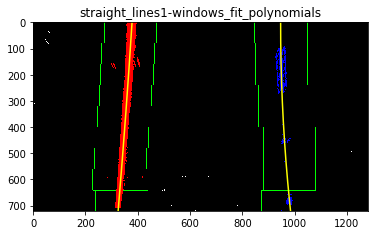

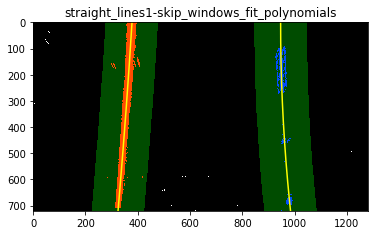

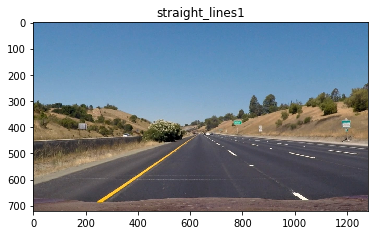

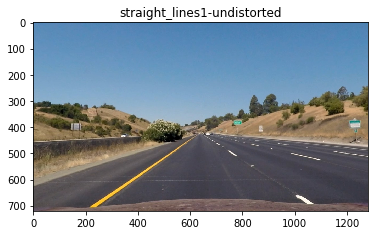

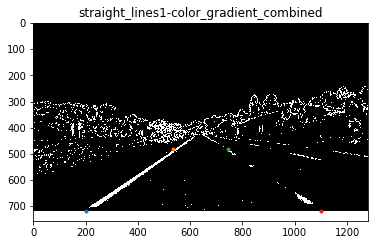

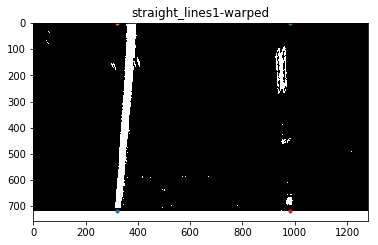

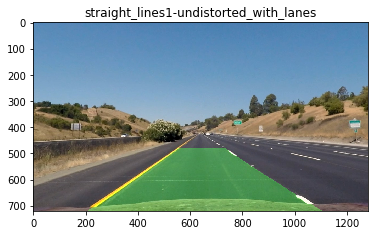

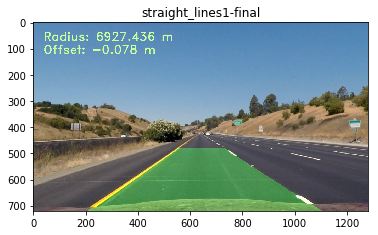

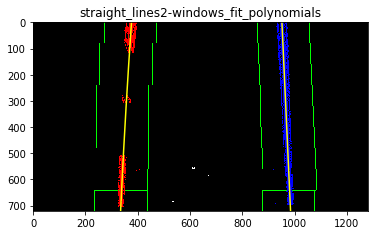

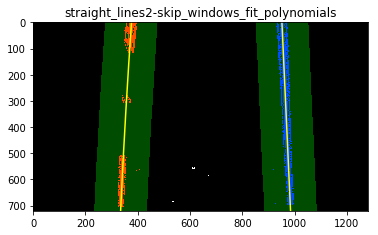

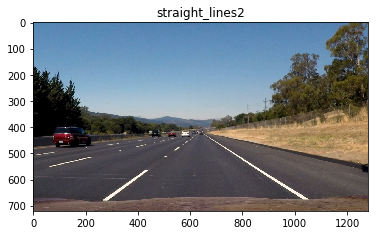

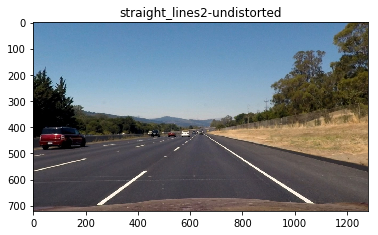

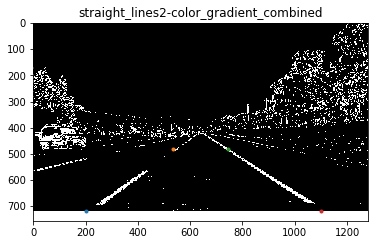

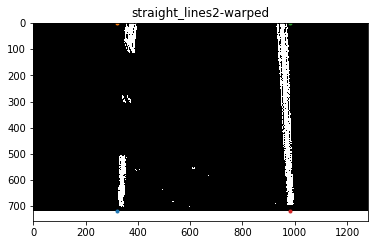

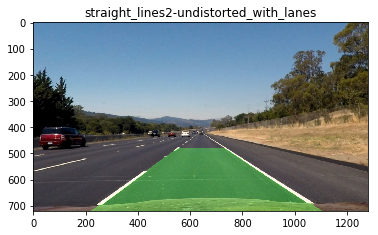

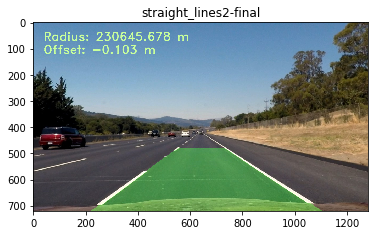

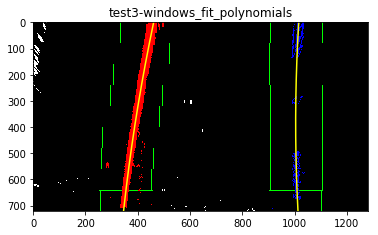

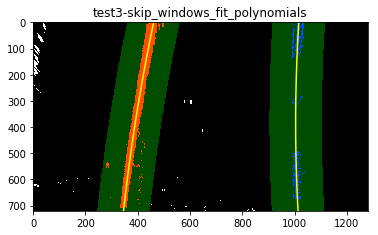

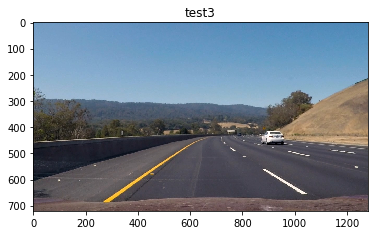

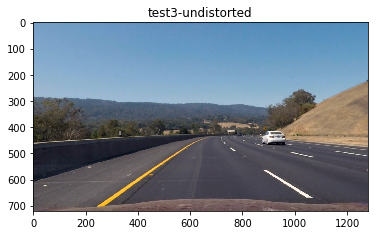

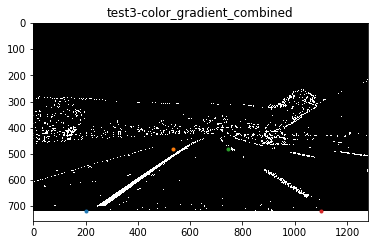

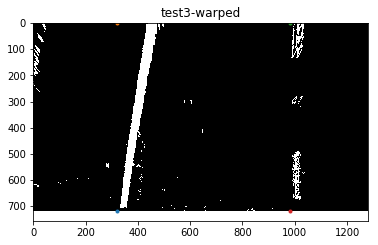

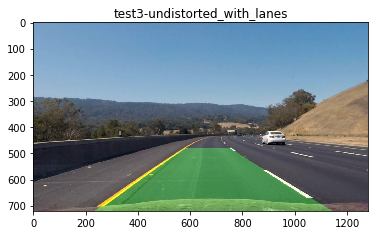

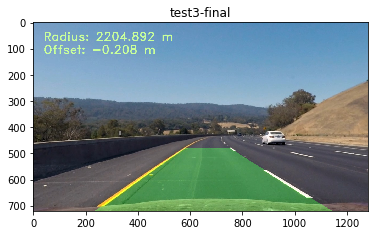

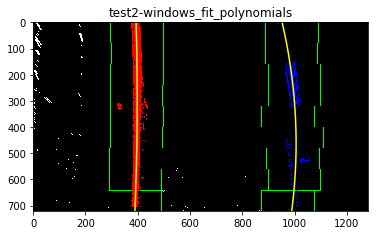

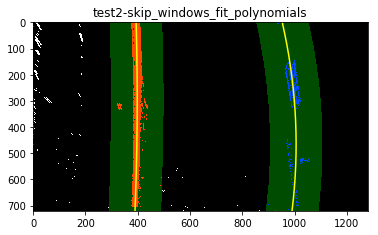

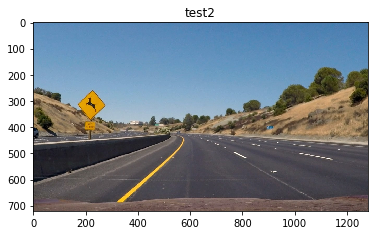

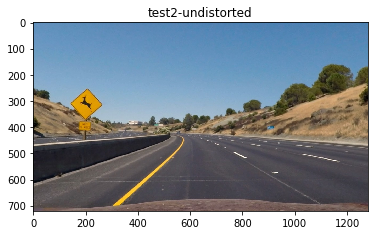

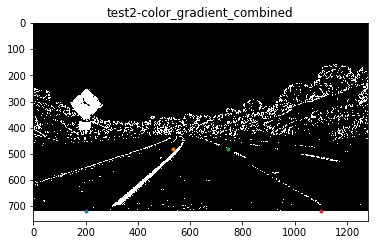

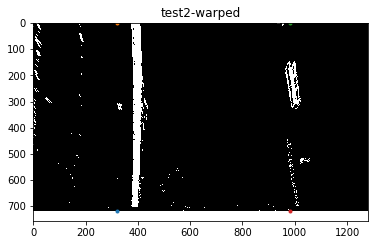

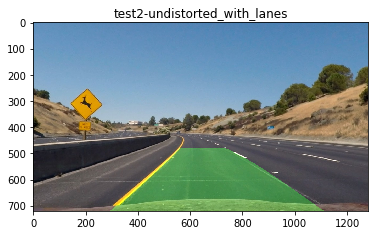

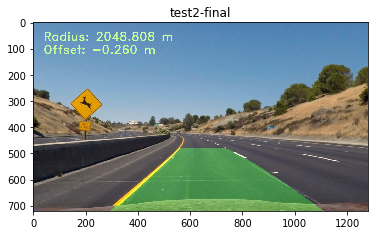

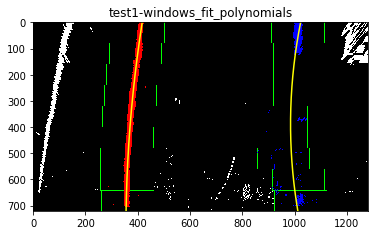

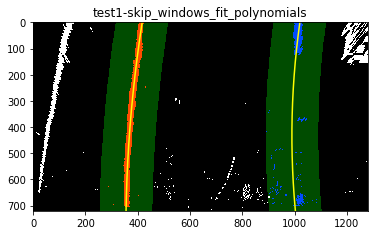

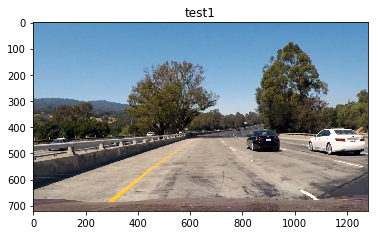

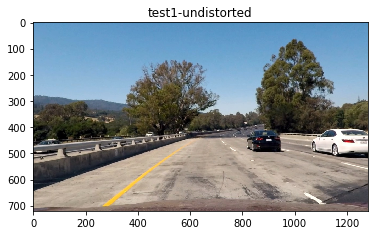

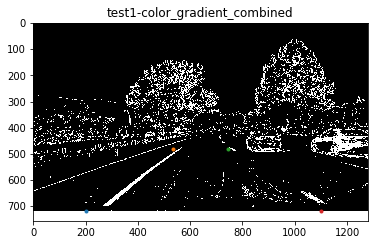

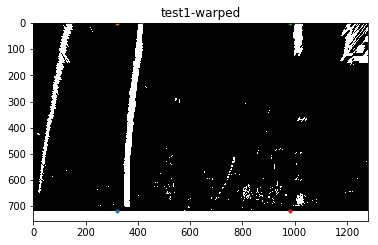

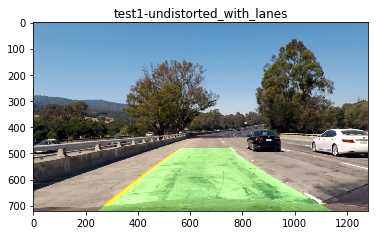

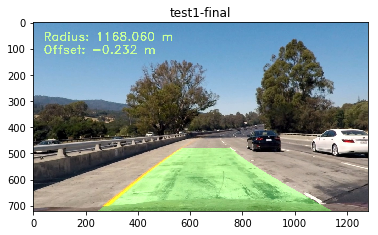

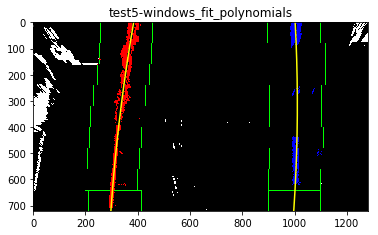

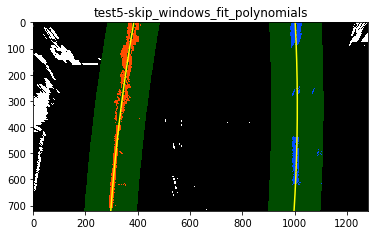

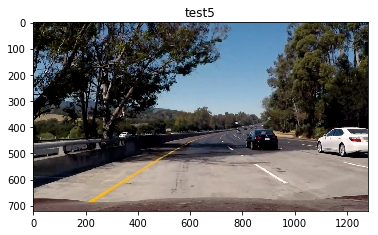

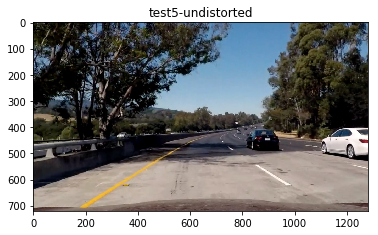

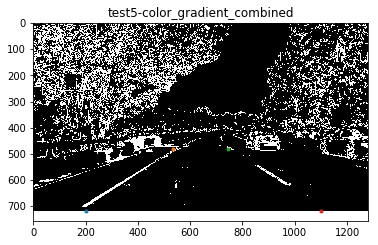

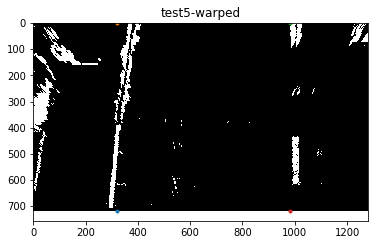

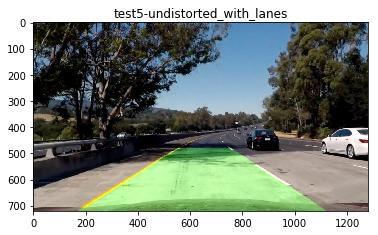

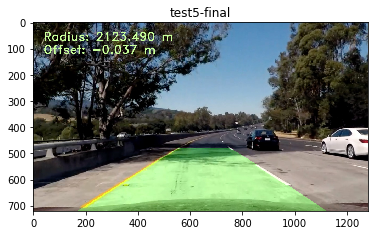

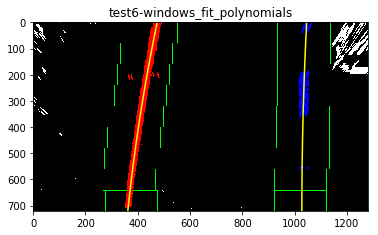

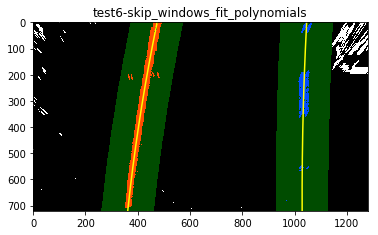

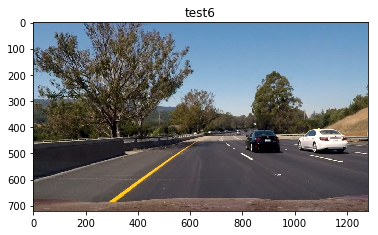

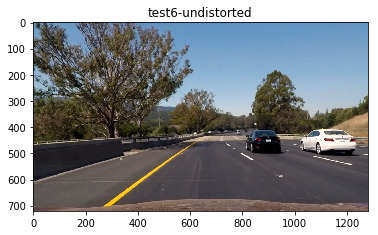

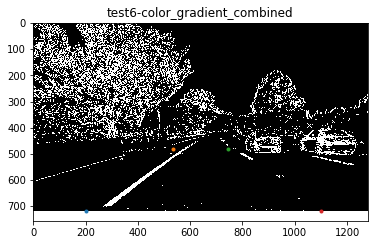

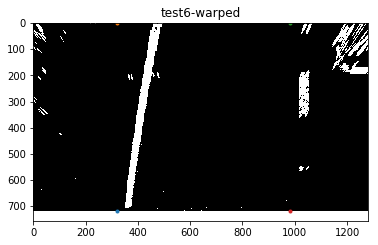

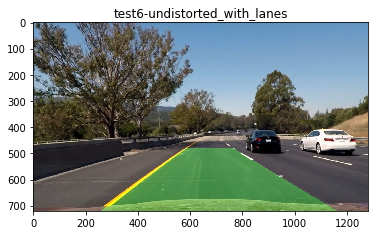

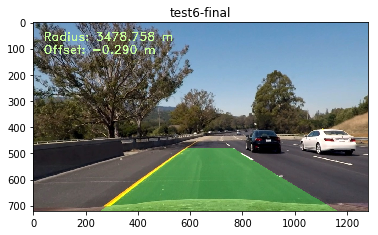

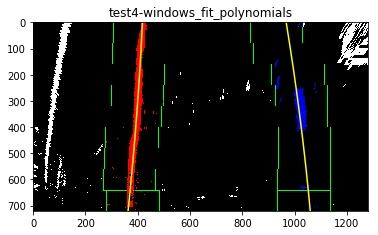

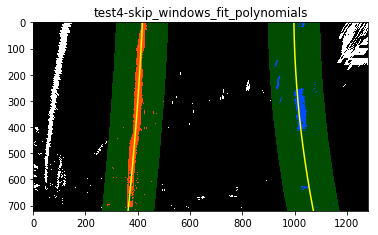

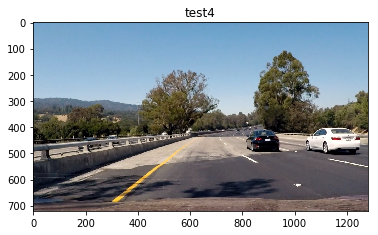

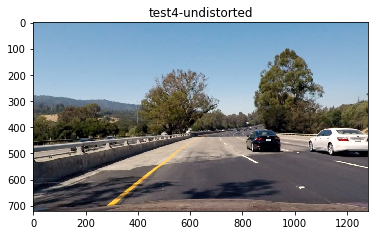

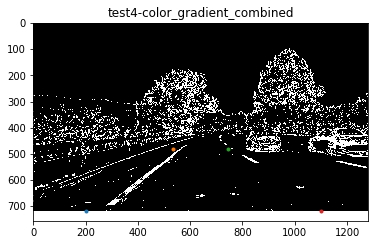

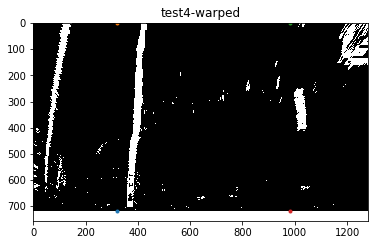

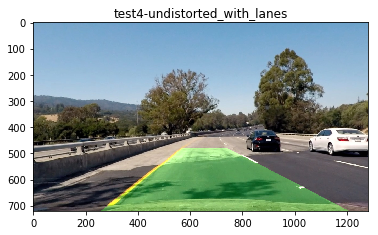

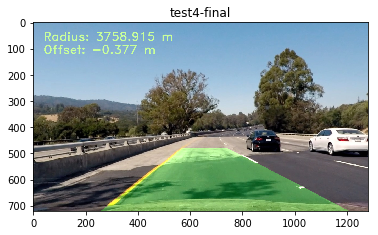

In [147]:
import os
test_images = "test_images/"
for img_src in os.listdir(test_images):
    tracker.reset()
    img = mpimg.imread(test_images+img_src)
    pipeline(img,True,img_src[:-4])

In [154]:
def process(img):
    return pipeline(img)    

In [142]:
from moviepy.editor import VideoFileClip

In [155]:
tracker.reset()
video_input = VideoFileClip('project_video.mp4')#.subclip(0,5)
processed_video = video_input.fl_image(process)
%time processed_video.write_videofile('project_video_output.mp4', audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 12%|█▏        | 152/1261 [03:07<23:32,  1.27s/it]


 24%|██▍       | 303/1261 [06:13<20:03,  1.26s/it]


 36%|███▌      | 454/1261 [09:33<18:57,  1.41s/it]


 48%|████▊     | 605/1261 [13:04<14:49,  1.36s/it]


 60%|█████▉    | 756/1261 [16:31<11:50,  1.41s/it]


 72%|███████▏  | 907/1261 [19:58<08:07,  1.38s/it]


 84%|████████▍ | 1057/1261 [23:37<04:43,  1.39s/it]


 96%|█████████▌| 1205/1261 [27:01<01:17,  1.38s/it]


100%|█████████▉| 1260/1261 [28:16<00:01,  1.41s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1h 1min 10s, sys: 17.4 s, total: 1h 1min 28s
Wall time: 28min 18s
